## Martin Dionne

In [1]:
import tarfile
import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split

#import tensorflow as tf
from tensorflow import keras

# FFNN
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import Dropout

# RNN
from keras.preprocessing import sequence
from keras.layers import Input
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import GRU
from keras.layers.recurrent import LSTM

# 1. Sentiment analysis

Using the [Large Movie Review Dataset](http://ai.stanford.edu/~amaas/data/sentiment/), we want to do a regression model that predict the ratings are on a 1-10 scale. You have an example train and test set in the `dataset` folder.

### 1.1 Regression Model

Use a feedforward neural network and NLP techniques we've seen up to now to train the best model you can on this dataset

### 1.2 RNN model

Train a RNN to do the sentiment analysis regression. The RNN should consist simply of an embedding layer (to make word IDs into word vectors) a recurrent blocks (GRU or LSTM) feeding into an output layer.

In [2]:
def get_review(member):
    with tar.extractfile(member) as f:
        review = f.read().decode()
        return review

data = []
with tarfile.open("dataset/aclImdb_v1.tar.gz", "r:gz") as tar:
    for member in tar.getmembers():
        if member.isreg(): 
            if 'train' in member.name:
                if '/neg/' in member.name:
                    score_10 = member.name[-5:-4]
                    score = 0
                    data.append([get_review(member), score, score_10])
                elif '/pos/' in member.name:
                    score_10 = member.name[-6:-4].replace('_','')
                    score = 1
                    data.append([get_review(member), score, score_10])
                else:
                    pass

In [3]:
train = pd.DataFrame(data, columns = ['Review', 'Score', 'Score_10'])
#train.sample(5)

In [18]:
#test.to_csv('dataset/imdb_test.csv', index=False)
#train.to_csv('dataset/imdb_train.csv', index=False)

df = pd.read_csv('dataset/imdb_train.csv')
df = pd.concat([df, pd.read_csv('dataset/imdb_test.csv')])
df = df.sample(frac=.5).reset_index(drop=True)
df

,Review,Score,Score_10
0,"Wrestlemania 6, is an entertaining Wrestlemani...",1,7
1,There is an inherent problem with commenting o...,0,2
2,"Now, I realize that most people on here trash ...",1,9
3,This movie was really stupid and I thought tha...,0,3
4,I consider this film to be a complete masterpi...,1,10
...,...,...,...
24995,Swoon focuses on Leopold and Loeb's homosexual...,0,1
24996,A Give this Movie a 10/10 because it deserves ...,1,10
24997,"If you like soap-series, you might like this f...",0,3
24998,Going to need to take a deep breath for this o...,0,1


array([ 7,  2,  9,  3, 10,  4,  8,  1], dtype=int64)

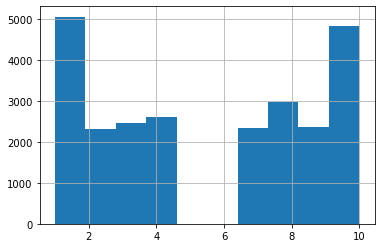

In [66]:
df['Score_10'].hist()
df['Score_10'].unique()

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer

def clean_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = text.lower()
    text = re.sub("\\s", " ", text)
    text = re.sub("[^a-zA-Z' ]", "", text)
    #text = text.split(' ')
    return text

tfidf = TfidfVectorizer(
    stop_words="english",
    preprocessor=clean_text,
    ngram_range=(1, 2),
    max_df=0.95,
    min_df=2,
    max_features=3000
)

In [56]:
from keras.utils import to_categorical

X = tfidf.fit_transform(df["Review"]).toarray()
y = to_categorical(df["Score_10"])
#y = df["Score"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
np.shape(X_train)

(20000, 3000)

In [57]:
# FFNN Model
num_classes = 11

model = keras.Sequential()
# Input layer
model.add(Dense(1600, input_dim=3000))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
# hidden layer
model.add(Dense(400))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
# hidden layer
model.add(Dense(100))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
# Output Layer
model.add(Dense(num_classes))
model.add(BatchNormalization())
model.add(Activation('softmax'))

#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 1600)              4801600   
_________________________________________________________________
batch_normalization_40 (Batc (None, 1600)              6400      
_________________________________________________________________
activation_40 (Activation)   (None, 1600)              0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 1600)              0         
_________________________________________________________________
dense_45 (Dense)             (None, 400)               640400    
_________________________________________________________________
batch_normalization_41 (Batc (None, 400)               1600      
_________________________________________________________________
activation_41 (Activation)   (None, 400)             

In [58]:
# Fit and evaluate
batch_size = 128
epochs = 5

history = model.fit(X_train, y_train, batch_size=batch_size, 
                    epochs=epochs, validation_split=0.15, verbose=1)

scores = model.evaluate(X_test, y_test, verbose=0)

print(f'Loss: {(scores[0]*100):.2f}')
print(f'Accuracy: {(scores[1]*100):.2f}')

Epoch 1/5
133/133 [==============================] - 6s 40ms/step - loss: 2.4739 - accuracy: 0.1654 - val_loss: 2.3127 - val_accuracy: 0.1373
Epoch 2/5
133/133 [==============================] - 5s 39ms/step - loss: 1.7631 - accuracy: 0.4170 - val_loss: 2.1912 - val_accuracy: 0.1570
Epoch 3/5
133/133 [==============================] - 5s 39ms/step - loss: 1.4889 - accuracy: 0.5353 - val_loss: 1.9137 - val_accuracy: 0.3373
Epoch 4/5
133/133 [==============================] - 5s 39ms/step - loss: 1.2497 - accuracy: 0.6282 - val_loss: 1.7540 - val_accuracy: 0.3747
Epoch 5/5
133/133 [==============================] - 5s 39ms/step - loss: 1.0052 - accuracy: 0.7218 - val_loss: 1.7953 - val_accuracy: 0.3690
Loss: 180.93
Accuracy: 35.60


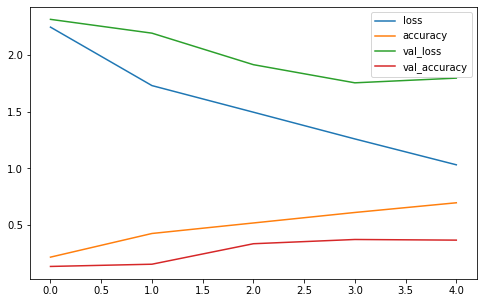

In [59]:
pd.DataFrame(history.history).plot(figsize=(8,5));

In [60]:
from tensorflow.keras.preprocessing.text import Tokenizer
vocab = 3000
max_len = 500

df['Review'] = df['Review'].apply(lambda x: clean_text(x))
tokenizer = Tokenizer(num_words=vocab)
tokenizer.fit_on_texts(df['Review'])
X = tokenizer.texts_to_sequences(df['Review'])
y = to_categorical(df["Score_10"])
#y = df["Score"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#np.shape(X_train)

In [61]:
# GRU Model
num_classes = 11

model = keras.Sequential()
# Input layer
model.add(Embedding(vocab, 128, input_length=max_len))
model.add(GRU(128, dropout=0.5, recurrent_dropout=0.5))
model.add(Dense(64, activation='relu'))
# Output layer
model.add(Dense(num_classes, activation='sigmoid'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 128)          384000    
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dense_48 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_49 (Dense)             (None, 11)                715       
Total params: 492,043
Trainable params: 492,043
Non-trainable params: 0
_________________________________________________________________


In [62]:
# Fit and evaluate

batch_size = 64
epochs = 5

X_train = sequence.pad_sequences(X_train, maxlen=max_len)
X_test = sequence.pad_sequences(X_test, maxlen=max_len)

history = model.fit(X_train, y_train, batch_size=batch_size, 
                    epochs=epochs, validation_split=0.15, verbose=1)

scores = model.evaluate(X_test, y_test, verbose=0)

print(f'Loss: {(scores[0]*100):.2f}')
print(f'Accuracy: {(scores[1]*100):.2f}')

Epoch 1/5
266/266 [==============================] - 973s 4s/step - loss: 2.1084 - accuracy: 0.2124 - val_loss: 1.7620 - val_accuracy: 0.3250
Epoch 2/5
266/266 [==============================] - 952s 4s/step - loss: 1.6740 - accuracy: 0.3630 - val_loss: 1.5852 - val_accuracy: 0.3747
Epoch 3/5
266/266 [==============================] - 949s 4s/step - loss: 1.4593 - accuracy: 0.4278 - val_loss: 1.5194 - val_accuracy: 0.4040
Epoch 4/5
266/266 [==============================] - 942s 4s/step - loss: 1.3556 - accuracy: 0.4688 - val_loss: 1.5430 - val_accuracy: 0.3790
Epoch 5/5
266/266 [==============================] - 937s 4s/step - loss: 1.2839 - accuracy: 0.4982 - val_loss: 1.5148 - val_accuracy: 0.4093
Loss: 148.79
Accuracy: 41.02


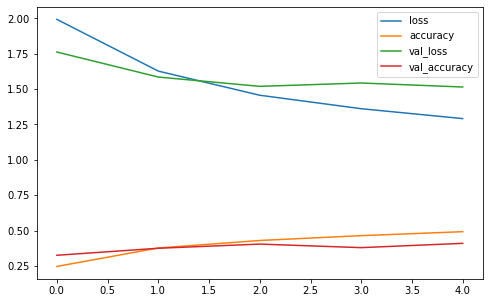

In [63]:
pd.DataFrame(history.history).plot(figsize=(8,5));

# 2. (evil) XOR Problem

Train an LSTM to solve the XOR problem: that is, given a sequence of bits, determine its parity. The LSTM should consume the sequence, one bit at a time, and then output the correct answer at the sequence’s end. Test the two approaches below:

### 2.1 

Generate a dataset of random <=100,000 binary strings of equal length <= 50. Train the LSTM; what is the maximum length you can train up to with precisison?
    

### 2.2

Generate a dataset of random <=200,000 binary strings, where the length of each string is independently and randomly chosen between 1 and 50. Train the LSTM. Does it succeed? What explains the difference?


In [14]:
def generate_bits(nval=100_000, length=50, random=False, pairs=True):
    if random:
        X = [ [np.random.randint(2) for l in range(np.random.randint(1,length))] for n in range(nval) ]
        X = np.array(sequence.pad_sequences(X, maxlen=length))
    else:
        X = np.random.randint(2, size=(nval, length))

    Y = [np.cumsum(x) % 2 for x in X]
    
    if pairs:
        make_pairs = lambda z: [z, int(not(z))]
        X = [ [make_pairs(j) for j in i] for i in X ]
        Y = [ [make_pairs(j) for j in i] for i in Y ]

    return  np.array(X), np.array(Y)

In [17]:
nval = 100_000
length = 50

X, Y = generate_bits(nval=100_000, length=50, random=False, pairs=True)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
np.shape(X_train)

(80000, 50, 2)

In [18]:
# LSTM model (fixed length)

model = keras.Sequential()

model.add(Input(shape=(length, 2), dtype='float32'))
model.add(LSTM(1, return_sequences=True))
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 1)             16        
_________________________________________________________________
dense_6 (Dense)              (None, 50, 2)             4         
Total params: 20
Trainable params: 20
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Fit and evaluate

batch_size = 128
epochs = 10

history = model.fit(X_train, Y_train, batch_size=batch_size, 
                    epochs=epochs, validation_split=0.15, verbose=1)

scores = model.evaluate(X_test, Y_test, verbose=0)

print(f'Loss: {(scores[0]*100):.2f}')
print(f'Accuracy: {(scores[1]*100):.2f}')

Epoch 1/10
532/532 [==============================] - 22s 32ms/step - loss: 0.6931 - accuracy: 0.5091 - val_loss: 0.6929 - val_accuracy: 0.5073
Epoch 2/10
532/532 [==============================] - 15s 28ms/step - loss: 0.6928 - accuracy: 0.5093 - val_loss: 0.6925 - val_accuracy: 0.5151
Epoch 3/10
532/532 [==============================] - 14s 26ms/step - loss: 0.6921 - accuracy: 0.5150 - val_loss: 0.6897 - val_accuracy: 0.5198
Epoch 4/10
532/532 [==============================] - 14s 26ms/step - loss: 0.6868 - accuracy: 0.5342 - val_loss: 0.6623 - val_accuracy: 0.6223
Epoch 5/10
532/532 [==============================] - 14s 27ms/step - loss: 0.5427 - accuracy: 0.7867 - val_loss: 0.2522 - val_accuracy: 1.0000
Epoch 6/10
532/532 [==============================] - 14s 26ms/step - loss: 0.2292 - accuracy: 1.0000 - val_loss: 0.1780 - val_accuracy: 1.0000
Epoch 7/10
532/532 [==============================] - 14s 26ms/step - loss: 0.1662 - accuracy: 1.0000 - val_loss: 0.1374 - val_accuracy:

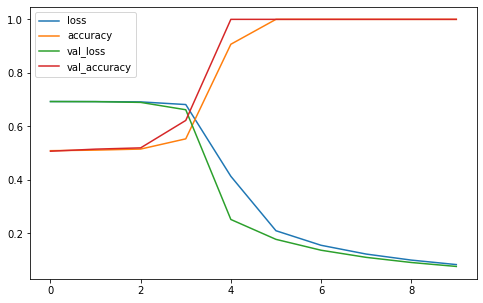

In [20]:
pd.DataFrame(history.history).plot(figsize=(8,5));

In [21]:
nval = 200_000
length = 50

X, Y = generate_bits(nval=200_000, length=50, random=True, pairs=True)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
np.shape(X_train)

(160000, 50, 2)

In [22]:
# LSTM model (random length)

model = keras.Sequential()

model.add(Input(shape=(length, 2), dtype='float32'))
model.add(LSTM(1, return_sequences=True))
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 1)             16        
_________________________________________________________________
dense_7 (Dense)              (None, 50, 2)             4         
Total params: 20
Trainable params: 20
Non-trainable params: 0
_________________________________________________________________


In [23]:
# Fit and evaluate
batch_size = 128
epochs = 5

history = model.fit(X_train, Y_train, batch_size=batch_size, 
                    epochs=epochs, validation_split=0.15, verbose=1)

scores = model.evaluate(X_test, Y_test, verbose=0)

print(f'Loss: {(scores[0]*100):.2f}')
print(f'Accuracy: {(scores[1]*100):.2f}')

Epoch 1/5
1063/1063 [==============================] - 35s 28ms/step - loss: 0.5583 - accuracy: 0.7506 - val_loss: 0.4329 - val_accuracy: 0.7523
Epoch 2/5
1063/1063 [==============================] - 29s 27ms/step - loss: 0.4124 - accuracy: 0.7513 - val_loss: 0.3558 - val_accuracy: 0.7734
Epoch 3/5
1063/1063 [==============================] - 32s 30ms/step - loss: 0.3469 - accuracy: 0.7828 - val_loss: 0.2477 - val_accuracy: 0.9280
Epoch 4/5
1063/1063 [==============================] - 32s 30ms/step - loss: 0.1689 - accuracy: 0.9828 - val_loss: 0.0876 - val_accuracy: 1.0000
Epoch 5/5
1063/1063 [==============================] - 31s 29ms/step - loss: 0.0783 - accuracy: 1.0000 - val_loss: 0.0564 - val_accuracy: 1.0000
Loss: 5.65
Accuracy: 100.00


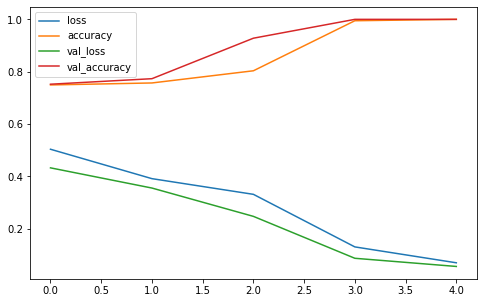

In [24]:
pd.DataFrame(history.history).plot(figsize=(8,5));

In [ ]:
# random (smaller) lengths of bits converge faster